In [1]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import OrderedDict

# Import PyTorch
import torch # import main library
from torch.autograd import Variable
import torch.nn as nn # import modules
from torch.autograd import Function # import Function to create custom activations
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters
from torch import optim # import optimizers for demonstrations
import torch.nn.functional as F # import torch functions
from torchvision import datasets, transforms # import transformations to use for demo


In [13]:
  # Define a transform
  transform = transforms.Compose([transforms.ToTensor()])

  # Download and load the training data for Fashion MNIST
  trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [30]:

# helper function to train a model
def train_model(model, trainloader, epochs=5):
    '''
    Function trains the model and prints out the training log.
    INPUT:
        model - initialized PyTorch model ready for training.
        trainloader - PyTorch dataloader for training data.
    '''
    #setup training

    #define loss function
    criterion = nn.NLLLoss()
    #define learning rate
    learning_rate = 0.003
    #initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #run training and print out the loss to make sure that we are actually fitting to the training set
    print('Training the model. Make sure that loss decreases after each epoch.\n')
    loss_records = []
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1)
            log_ps = model(images)
            loss = criterion(log_ps, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        else:
            # print out the loss to make sure it is decreasing
            print(f"Training loss: {running_loss}")
            
        loss_records.append(running_loss)
            
    return loss_records


In [5]:

# simply define a silu function
def silu(input):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:
        SiLU(x) = x * sigmoid(x)
    '''
    return input * torch.sigmoid(input) # use torch.sigmoid to make sure that we created the most efficient implemetation based on builtin PyTorch functions

# create a class wrapper from PyTorch nn.Module, so
# the function now can be easily used in models
class SiLU(nn.Module):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:
        SiLU(x) = x * sigmoid(x)
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    References:
        -  Related paper:
        https://arxiv.org/pdf/1606.08415.pdf
    Examples:
        >>> m = silu()
        >>> input = torch.randn(2)
        >>> output = m(input)
    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return silu(input) # simply apply already implemented SiLU


In [7]:

# use SiLU with model created with Sequential

# initialize activation function
activation_function = SiLU()

# Initialize the model using nn.Sequential
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(784, 256)),
                      ('activation1', activation_function), # use SiLU
                      ('fc2', nn.Linear(256, 128)),
                      ('bn2', nn.BatchNorm1d(num_features=128)),
                      ('activation2', activation_function), # use SiLU
                      ('dropout', nn.Dropout(0.3)),
                      ('fc3', nn.Linear(128, 64)),
                      ('bn3', nn.BatchNorm1d(num_features=64)),
                      ('activation3', activation_function), # use SiLU
                      ('logits', nn.Linear(64, 10)),
                      ('logsoftmax', nn.LogSoftmax(dim=1))]))

# Run training
train_model(model, trainloader)


Training the model. Make sure that loss decreases after each epoch.

Training loss: 471.4954441636801
Training loss: 341.5519505441189
Training loss: 309.5684223920107
Training loss: 291.05133636295795
Training loss: 274.3823933750391


In [10]:

class soft_exponential(nn.Module):
    '''
    Implementation of soft exponential activation.
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    Parameters:
        - alpha - trainable parameter
    References:
        - See related paper:
        https://arxiv.org/pdf/1602.01321.pdf
    Examples:
        >>> a1 = soft_exponential(256)
        >>> x = torch.randn(256)
        >>> x = a1(x)
    '''
    def __init__(self, in_features, alpha = None):
        '''
        Initialization.
        INPUT:
            - in_features: shape of the input
            - aplha: trainable parameter
            aplha is initialized with zero value by default
        '''
        super(soft_exponential,self).__init__()
        self.in_features = in_features

        # initialize alpha
        if alpha == None:
            self.alpha = Parameter(torch.tensor(0.0)) # create a tensor out of alpha
        else:
            self.alpha = Parameter(torch.tensor(alpha)) # create a tensor out of alpha
            
        self.alpha.requiresGrad = True # set requiresGrad to true!

    def forward(self, x):
        '''
        Forward pass of the function.
        Applies the function to the input elementwise.
        '''
        if (self.alpha == 0.0):
            return x

        if (self.alpha < 0.0):
            return - torch.log(1 - self.alpha * (x + self.alpha)) / self.alpha

        if (self.alpha > 0.0):
            return (torch.exp(self.alpha * x) - 1)/ self.alpha + self.alpha



In [18]:
class adaptive_relu(nn.Module):
    def __init__(self, in_features, alpha=None):
        super(adaptive_relu, self).__init__()
        self.in_features = in_features
        
        # initialize alpha
        if alpha == None:
            self.alpha = Parameter(torch.tensor(1.0)) # create a tensor out of alpha
        else:
            self.alpha = Parameter(torch.tensor(alpha)) # create a tensor out of alpha
            
        self.alpha.requiresGrad = True # set requiresGrad to true!        
        
    def forward(self, x):
        return self.alpha * x.clamp(min=0)


In [22]:
import matplotlib.pyplot as plt

Training the model. Make sure that loss decreases after each epoch.

Training loss: 482.4293819218874
Training loss: 353.85101406276226
Training loss: 321.3158094063401
Training loss: 298.9575671479106
Training loss: 287.5212336704135
Training loss: 275.09870958328247
Training loss: 264.70206071436405
Training loss: 253.61597473919392
Training loss: 246.37375557422638
Training loss: 239.96719767153263
Training loss: 235.48962399363518
Training loss: 228.45708268508315
Training loss: 223.462989423424
Training loss: 219.65001448988914
Training loss: 211.18569223210216
Training the model. Make sure that loss decreases after each epoch.

Training loss: 487.8173965513706
Training loss: 356.13539984822273
Training loss: 320.6074129343033
Training loss: 298.69811776280403
Training loss: 280.4814757928252
Training loss: 265.92548632621765
Training loss: 253.47678147256374
Training loss: 244.5852853730321
Training loss: 234.32841899245977
Training loss: 224.80393916368484
Training loss: 217.031

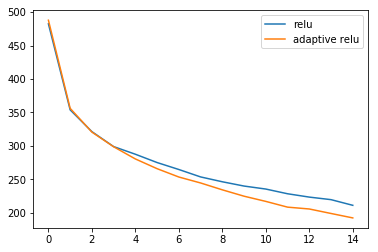

<Figure size 432x288 with 0 Axes>

In [35]:

# create class for basic fully-connected deep neural network
class Classifier_adaptive(nn.Module):
    '''
    Basic fully-connected network to test adaptive-relu activation.
    '''
    def __init__(self):
        super().__init__()

        # initialize layers
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        self.a1 = adaptive_relu(256)
        self.a2 = adaptive_relu(128)
        self.a3 = adaptive_relu(64)

    def forward(self, x):
        # make sure the input tensor is flattened
        x = x.view(x.shape[0], -1)

        # apply Soft Exponential unit
        x = self.a1(self.fc1(x))
        x = self.a2(self.fc2(x))
        x = self.a3(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x
    
class Classifier(nn.Module):
    '''
    Basic fully-connected network to test adaptive-relu activation.
    '''
    def __init__(self):
        super().__init__()

        # initialize layers
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        self.a1 = nn.ReLU(256)
        self.a2 = nn.ReLU(128)
        self.a3 = nn.ReLU(64)

    def forward(self, x):
        # make sure the input tensor is flattened
        x = x.view(x.shape[0], -1)

        # apply Soft Exponential unit
        x = self.a1(self.fc1(x))
        x = self.a2(self.fc2(x))
        x = self.a3(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x
    
model = Classifier()
adaptive_model = Classifier_adaptive()

loss = train_model(model, trainloader, epochs=15)
adaptive_loss = train_model(adaptive_model, trainloader, epochs=15)

plt.plot(loss, label='relu')
plt.plot(adaptive_loss, label='adaptive relu')
plt.legend()
plt.show()
plt.savefig('compare_relu.png')

In [15]:

# create class for basic fully-connected deep neural network
class ClassifierSExp(nn.Module):
    '''
    Basic fully-connected network to test Soft Exponential activation.
    '''
    def __init__(self):
        super().__init__()

        # initialize layers
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # initialize Soft Exponential activation
        self.a1 = soft_exponential(256)
        self.a2 = soft_exponential(128)
        self.a3 = soft_exponential(64)

    def forward(self, x):
        # make sure the input tensor is flattened
        x = x.view(x.shape[0], -1)

        # apply Soft Exponential unit
        x = self.a1(self.fc1(x))
        x = self.a2(self.fc2(x))
        x = self.a3(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x
    
model = ClassifierSExp()
train_model(model, trainloader, epochs=10)



Training the model. Make sure that loss decreases after each epoch.

Training loss: 557.7507739812136
Training loss: 468.71403078734875
Training loss: 446.58943282067776
Training loss: 435.0755684673786
Training loss: 427.3708694577217
Training loss: 420.4459821432829
Training loss: 418.87791903316975
Training loss: 407.3105629235506
Training loss: 414.770966604352
Training loss: 400.8003673553467
